这个文件是针对MCNP所模拟的Eu-152模拟能谱验证gamut的分析功能。

我们希望实现以下工作：

1.导入开箱即用的预定义γ谱分析管道网；
2.导入不同NPS下的模拟能谱，并且可视化他的几个主要的峰；
3.使用管道网对模拟能谱进行分析，以计数率最高的能谱作为基准，分析低计数率下的峰面积计算不准确性。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import gamspec

In [ ]:
pipenet = gamspec.default
spectrum = gamspec.Spectrum.from_MCNP('E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\Eu152sgl_test_new_0.36779.out')
pipenet([spectrum])

然后，我们希望导入预定义的管道网（分析流程）。

In [2]:
# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher(20)
# peakfilter = gamspec.PeakSearcher()
convol._min_height_ratio = 0.4
convol._min_height = 20
convol._min_area = 100
convol._min_area_ratio = 2
searcher = gamspec.CovarianceSearcher(10, 4, 'inverse')
searcher._merge_mode = "Old"
searcher._min_height_ratio = 0.4
searcher._min_height = 20
searcher._min_area = 100
searcher._min_area_ratio = 2

# def func(spectrum):
#     for region in spectrum.regions:
#         for peak in region._peaks:
#             if 'stderr' not in peak:
#                 peak['stderr'] = 4
#     return spectrum

# def func(spectrum):
#     for i, peak in enumerate(spectrum.peaks):
#         j = 0
#         while (i+j<len(spectrum.peaks)) and ('stderr' not in spectrum.peaks[i+j].keys()):
#             j += 1
#         k = 0
#         while (i-k >= 0) and ('stderr' not in spectrum.peaks[i-k].keys()):
#             k += 1
#         spectrum.peaks[i]['stderr'] = (spectrum.peaks[i+j]['stderr'] + spectrum.peaks[i-k]['stderr']) / 2

# opr = gamspec.Functionor(func)
ppeak = gamspec.Pipe([sav, convol, searcher])
fpeak = gamspec.Flow(ppeak, 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)

# wavelet = gamspec.SavitzkySmoother(3, 4)
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1)

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 5, 0)


# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(3, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 5, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, ffit])
# pipenet([bench])

In [3]:
import pathlib
import pandas as pd
from re import match

folder = pathlib.Path(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\test spectra')
files = folder.glob('*.out')

combined_results = []
specs = []
for file in files:
    output = folder / (file.stem +'.xlsx')
    if output.exists():
        df = pd.read_excel(str(output))
        spec = gamspec.Spectrum.from_xml(folder / (file.stem +'.xml'))
    else:
        spectrum = gamspec.Spectrum.from_MCNP(str(file))
        pipenet([spectrum])
        spec = pipenet.get_node(4)[0]
        spec.export_to_xml(folder / (file.stem +'.xml'))
        df = spec.export_to_pandas()
        df.to_excel(str(output))
    df['NPS'] = int(match(r'Eu152_test_new_(\d+)', file.stem).group(1))
    combined_results.append(df)
    specs.append(spec)

In [4]:
energies = np.array([40.12, 45.40, 121.78, 244.70, 344.28, 367.79, 411.11, 443.98, 688.68, 778.90, 867.39, 964.13, 1085.91, 1089.70, 1112.12, 1212.95, 1299.12])
percentages = np.array([29.119E-2, 7.304E-2, 14.016E-2, 3.697E-2, 13.128E-2, 0.410E-2, 1.101E-2, 1.372E-2, 0.412E-2, 6.396E-2, 2.048E-2, 7.077E-2, 4.896E-2, 0.844E-2, 6.687E-2, 0.690E-2, 0.802E-2])
def energy_in_group(energy):
    if len(np.where(np.abs(energy-energies)<2)[0]) == 0:
        return None
    else:
        return np.where(np.abs(energy-energies)<2)[0][0]

energy_in_group(411)

6

In [5]:
results = pd.concat(combined_results)
func = lambda x: percentages[energy_in_group(x['energy'])] if energy_in_group(x['energy']) is not None else 0
results['percentage'] = results.apply(func, axis=1)

In [6]:
results

,Unnamed: 0,left,right,energy,location,height,stderr,area,sig_area2,fitness,NPS,percentage
0,0,7,75,5.863556,20,314.355985,1.279694,1008.365003,71.618487,0.445519,10000000,0.00000
1,1,7,75,9.674853,33,356.531517,23.284251,20808.948518,6019.951818,0.445519,10000000,0.00000
2,2,91,244,30.783572,105,2157.684050,2.509937,13575.023133,304.086505,0.963185,10000000,0.00000
3,3,91,244,34.008515,116,521.837534,81.336824,106392.853819,691045.885206,0.963185,10000000,0.00000
4,4,91,244,35.181221,120,914.892558,3.293284,7552.473277,390.278956,0.963185,10000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
22,22,3277,3306,964.258026,3289,528.741438,4.002499,5304.745372,107.086764,0.995925,6000000,0.07077
23,23,3686,3730,1086.219512,3705,323.422990,4.467171,3621.540959,68.436492,0.954334,6000000,0.04896
24,24,3779,3807,1112.312234,3794,428.544063,4.188980,4499.805629,96.027389,0.992534,6000000,0.06687
25,25,4127,4154,1213.165002,4138,44.098937,4.212608,465.660234,40.348032,0.990126,6000000,0.00690


In [7]:
# results = pd.concat(combined_results)
select_results = results.groupby('NPS')
new_select_results = []
interest = lambda x: True if energy_in_group(x['energy']) is not None else False
for group_key in select_results.groups.keys():
    df = select_results.get_group(group_key)
    df['interested'] = df.apply(interest, axis=1)
    print(df)
    df = df[df['interested']==True]
    new_select_results.append(df)
new_select_results = pd.concat(new_select_results)
new_select_results.to_excel('results_simulated_Eu152_selected.xlsx')

C:\Users\alber\AppData\Local\Temp\ipykernel_32628\3422614786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interested'] = df.apply(interest, axis=1)
C:\Users\alber\AppData\Local\Temp\ipykernel_32628\3422614786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['interested'] = df.apply(interest, axis=1)
C:\Users\alber\AppData\Local\Temp\ipykernel_32628\3422614786.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

    Unnamed: 0  left  right       energy  location         height     stderr  \
0            0    90    244    30.783572       105    1227.800025   2.171976   
1            1    90    244    32.249455       110     380.387090  18.797075   
2            2    90    244    35.181221       120     462.552149   2.429845   
3            3    90    244    39.578871       135     478.250164   3.762652   
4            4    90    244    45.149227       154     245.642458   3.717294   
5            5    90    244    54.530880       186     220.356841  39.591543   
6            6    90    244    60.980767       208  317222.939045   0.087189   
7            7   278    304    83.555369       285     122.621565  12.139623   
8            8   342    350   101.439144       346     147.029899   2.367695   
9            9   398    425   121.961510       416    4218.707994   2.509947   
10          10   449    458   132.515869       452     110.572441   3.123607   
11          11   572    582   168.869774

PermissionError: [Errno 13] Permission denied: 'results_simulated_Eu152_selected.xlsx'

In [24]:
out = spec.slice((100, 140)) >> gamspec.SNIPStripper(8, baseline=False) >> gamspec.RegionPeakFitter(3, baseline=True)
out.peaks

Fitting Region: 1~12, NPeaks=1, time=Tue Jan 30 01:08:36 2024
Finish Fitting Region: time=Tue Jan 30 01:08:37 2024
Fitting Region: 48~88, NPeaks=1, time=Tue Jan 30 01:08:37 2024
Finish Fitting Region: time=Tue Jan 30 01:08:37 2024
Fitting Region: 108~117, NPeaks=1, time=Tue Jan 30 01:08:37 2024
Finish Fitting Region: time=Tue Jan 30 01:08:38 2024


[{'location': 75,
  'center': 74.694692606144,
  'stderr': 2.399966264467025,
  'height': 6878.680438968929,
  'area': 41380.92603512217,
  'sig_center': 0.01507586754029987,
  'sig_stderr': 0.014088726433898293,
  'sig_height': 45.70315532007175,
  'sig_area': 466.3681006916718,
  'sig_area2': 227.07136387383747},
 {'location': 113,
  'center': 113.20924216265715,
  'stderr': 1.416753877843627,
  'height': 103.30857066949639,
  'area': 366.8771782304319,
  'sig_center': 0.15222479914216272,
  'sig_stderr': 0.14599919256828048,
  'sig_height': 8.739581567228914,
  'sig_area': 49.96266893134593,
  'sig_area2': 47.948229558176926}]

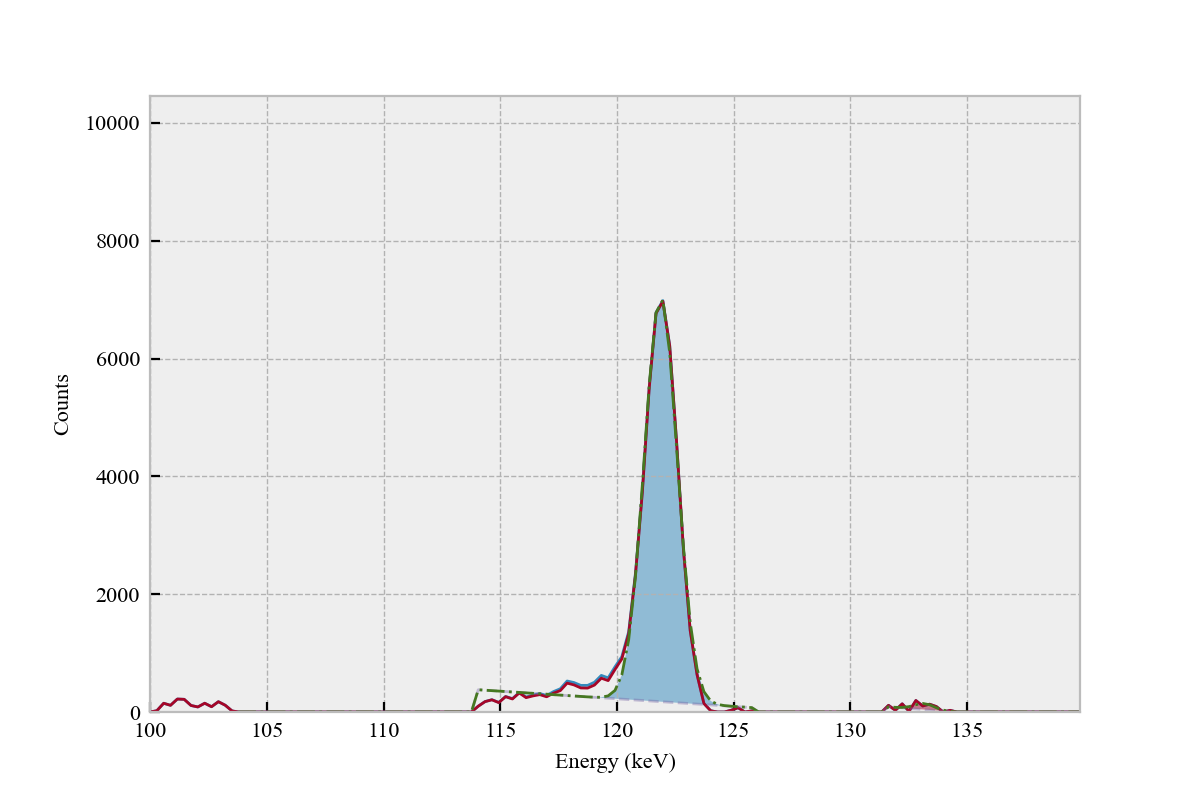

In [25]:
%matplotlib widget
plt.close()
# origin = gamspec.Spectrum.from_MCNP(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\test spectra\Eu152_test_new_6000000.out')
# origin.plot()
# spec = specs[0]
# spec.plot_peaks()
spec.plot()
out.plot()
out.plot_peaks()
plt.show()